In [1]:
import matplotlib.pyplot as plt
import numpy as np
from easydict import EasyDict as edict

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
###########
#Physical parameters
###########

#The Slippy rheology class will contain dimensional and nondimensional values, linked in a self-consistent way by scaling paramters
#lowermantle.nondimensional['cohesion']
#Where lowermantle is a material class (generated within a rheology class); and non dimensional is a dictionary

#UW naming conventions: 
#module_name, package_name, ClassName, function_name, method_name, 
#ExceptionName, propertyName GLOBAL_CONSTANT_NAME, globalVarName, instanceVarName, functionParameterName, localVarName
###########


#dimensional parameter dictionary
dp = edict({'LS':2890.*1e3,
           'rho':3300,
           'g':9.81, 
           'eta0':1e23,
           'k':10**-6,
           'a':1.25*10**-5, 
           'TS':273.,
           'TB':2773.,
           'deltaT':2500, 
           'cohesion':1e7, 
           'E':240000., 
           'R':8.314,
           'V':6.34*(10**-7),
           'StALS': 28.*1e3})

#non-dimensional parameter dictionary
#One draw back of a dictionary structure, is that variables cannot link to other variables
RAfac = 20.
Stressfac =(RAfac**(2/3.))
ndp = edict({'RA':1e6*RAfac,      
              'LS':1.,
              'eta0':1.,
              'StAeta0':0.1,
              'k':1.,
              'E':11.55,
              'V':3.0,
              'H':20.,
              'TR':(1600./2500.),
              'TS':(dp.TS/2500.),
              'RD':1.,
              'cohesion':1577.*RAfac,
              'cohesion_reduce':10.,
              'fc':0.1, 
              'low_visc':RAfac*1e-4,
              'up_visc':1e5,
              'random_temp': 0.05})


#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (27.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (300.*1e3)/dp.LS 
LITHTOMANTLE = (660.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (0.*1e3)/dp.LS  #rock-air topography limits
AVGTEMP = 0.53 #Used to define lithosphere

In [3]:
depths = np.linspace(0.01, 1., 100)
temps = np.linspace(0.01, 1., 100)
upper = np.ones(100)*ndp.up_visc
lower= np.ones(100)*ndp.low_visc

In [4]:
#np.where(depths > 0.9, depths, depths*5.)
for index, value in np.ndenumerate(depths):
    if value > 0.1 and value < 0.9:
        temps[index] = 0.5
    elif value < 0.1:
        temps[index] = 5.*value
    elif value >= 0.9:
        temps[index] = 1. - (5.*(1.-value))
        

In [5]:
#temps

In [6]:
#Linear viscosity
def arhennius(z, t):
    return np.maximum(lower, (np.minimum(upper, np.exp(((ndp.E + ndp.V*(1.-z))/
                                         ( t + ndp.TS)) - ((ndp.E + ndp.V*(1.- ndp.RD))/(ndp.TR + ndp.TS))))))

In [7]:
#depths

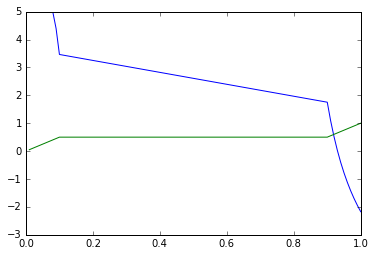

In [8]:
plt.plot(depths, np.log10(arhennius(depths, temps) ))
plt.plot(depths, temps)

In [9]:
depths

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
        0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,
        0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,
        0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,  0.81,
        0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,  0.9 ,
        0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99,  1.  ])

In [10]:
def lower_mantle(z, a, B, d0, ds):
    inner1 = 1. - 0.5*(1. - np.tanh((d0-(1.-z))/(ds)))
    modfac = a*np.exp(np.log(B)*inner1)
    return modfac

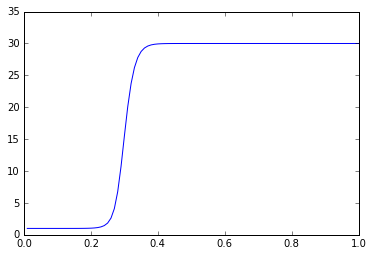

In [11]:
plt.plot(depths, lower_mantle(depths, 1., 30., (1. - 0.2758), 0.034))

In [12]:
def full_rheology(z, t,  a, B, d0, ds):
    arr1 = np.exp(((ndp.E + ndp.V*(1.-z))/
                                         ( t + ndp.TS)) - ((ndp.E + ndp.V*(1.- ndp.RD))/(ndp.TR + ndp.TS)))
    inner1 = 1. - 0.5*(1. - np.tanh((d0-(1.- z))/(ds)))
    modfac = a*np.exp(np.log(B)*inner1)
    arrmod = arr1*modfac
    return np.maximum(lower, (np.minimum(upper, arrmod)))

In [13]:
#full_rheology(depths, depths, 1., 30., 0.2758, 0.034)

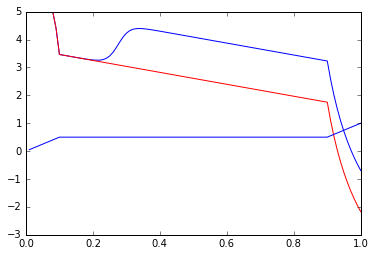

In [14]:
plt.plot(depths,np.log10(full_rheology(depths, temps, 1., 30., (1.-0.2758), 0.034)), c = 'b')
plt.plot(depths, np.log10(arhennius(depths, temps) ), c='r')
plt.plot(depths, temps)
#plt.plot(depths, lower_mantle(depths, 1., 30., (1. - 0.2758), 0.034))
#plt.plot(lower_mantle(depths, 1., 30., 0.2758, 0.034), depths)